## Бэггинг (bootstrap aggregation) 
— принцип построения композиции, построенный на простом голосовании. Обычно в случае бэггинга используются базовые алгоритмы из одного семейства. Пусть мы имеем N базовых алгоритмов: b 
1
​
 (x),b 
2
​
 (x),...,b 
n
​
 (x). Тогда в случае регрессии финальным ответом будет среднее по всем алгоритмам, а в случае классификации — решение через простое голосование: a(x)= 
N
a
​
 ∑ 
N
i
​
 b 
i
​
 (x). Описанный алгоритм, если в качестве базовых алгоритмов выступают решающие деревья, ещё называют **случайным лесом**.
 
 #### Бутстрэп
 — это метод повторной выборки с возвращением.  
Суть: из исходных данных случайно создаются новые выборки такого же размера с возвращением, на которых мы считаем нужные метрики или обучаем модели.

In [ ]:
from sklearn.ensemble import BaggingRegressor

base_pipe = Pipeline([("column_transformer",
                       col_transform),
                  
                     ("decision_tree", 
                      DecisionTreeRegressor(max_depth=10))])

bagging = BaggingRegressor(base_estimator=base_pipe,
                            n_estimators=10, random_state=32)

bagging.fit(X_train, y_train)

### Random Forest
Случайный лес — один из популярнейших способов применить бэггинг.

Суть в том, чтобы в качестве базовых моделей b 
1
​
 (x),b 
2
​
 (x),…,b 
N
​
 (x) взять решающие деревья. И желательно, чтобы базовые модели были максимально некоррелированные, чтобы прогнозы и ошибки были разные. Но как этого достичь?

Во-первых, рандомизация достигается за счет бутстрапа.
Во-вторых, включается **метод случайных подпространств**: при построении решающих деревьев выберется лучший предикат не среди всех 𝑚 признаков, а из случайно выбранных 𝑝 < 𝑚. Данная технология позволяет получать различные друг от друга решающие деревья и это добавляет рандомизации в построение базовых алгоритмов.  
**При решении задачи регрессии/классификации число выбираемых признаков должно быть равно примерно m/3 или корень из m (округляя вниз)**.

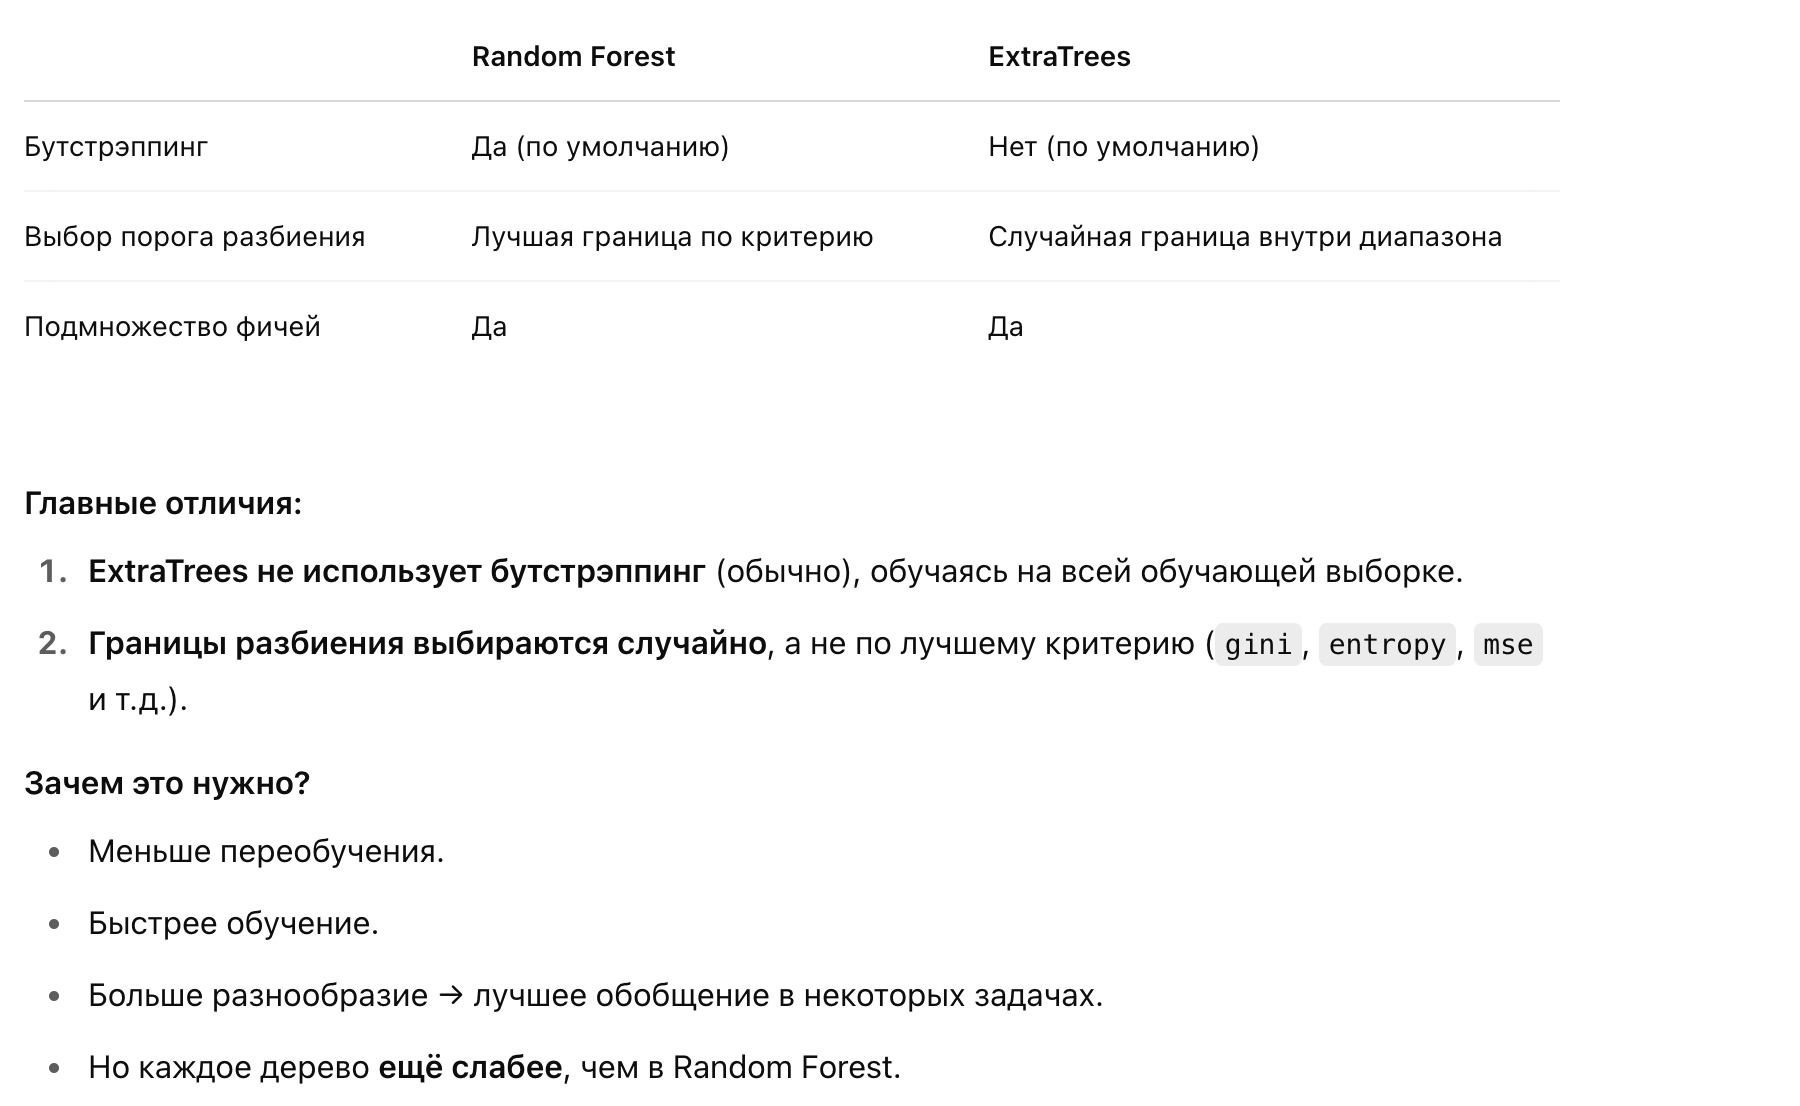

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Генерация искусственного датасета
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_redundant=5, n_classes=2, random_state=42)

# Делим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение Random Forest
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

# Обучение Extra Trees
et = ExtraTreesClassifier(n_estimators=100, max_features='sqrt', random_state=42)
et.fit(X_train, y_train)

# Предсказания
y_pred_rf = rf.predict(X_test)
y_pred_et = et.predict(X_test)

# Оценка
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Extra Trees Accuracy:", accuracy_score(y_test, y_pred_et))

# Дополнительно: важность признаков
plt.figure(figsize=(10, 5))
plt.bar(range(X.shape[1]), rf.feature_importances_, alpha=0.6, label='Random Forest')
plt.bar(range(X.shape[1]), et.feature_importances_, alpha=0.6, label='Extra Trees')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Сравнение важности признаков')
plt.legend()
plt.tight_layout()
plt.show()


### Out-of-bag ошибка
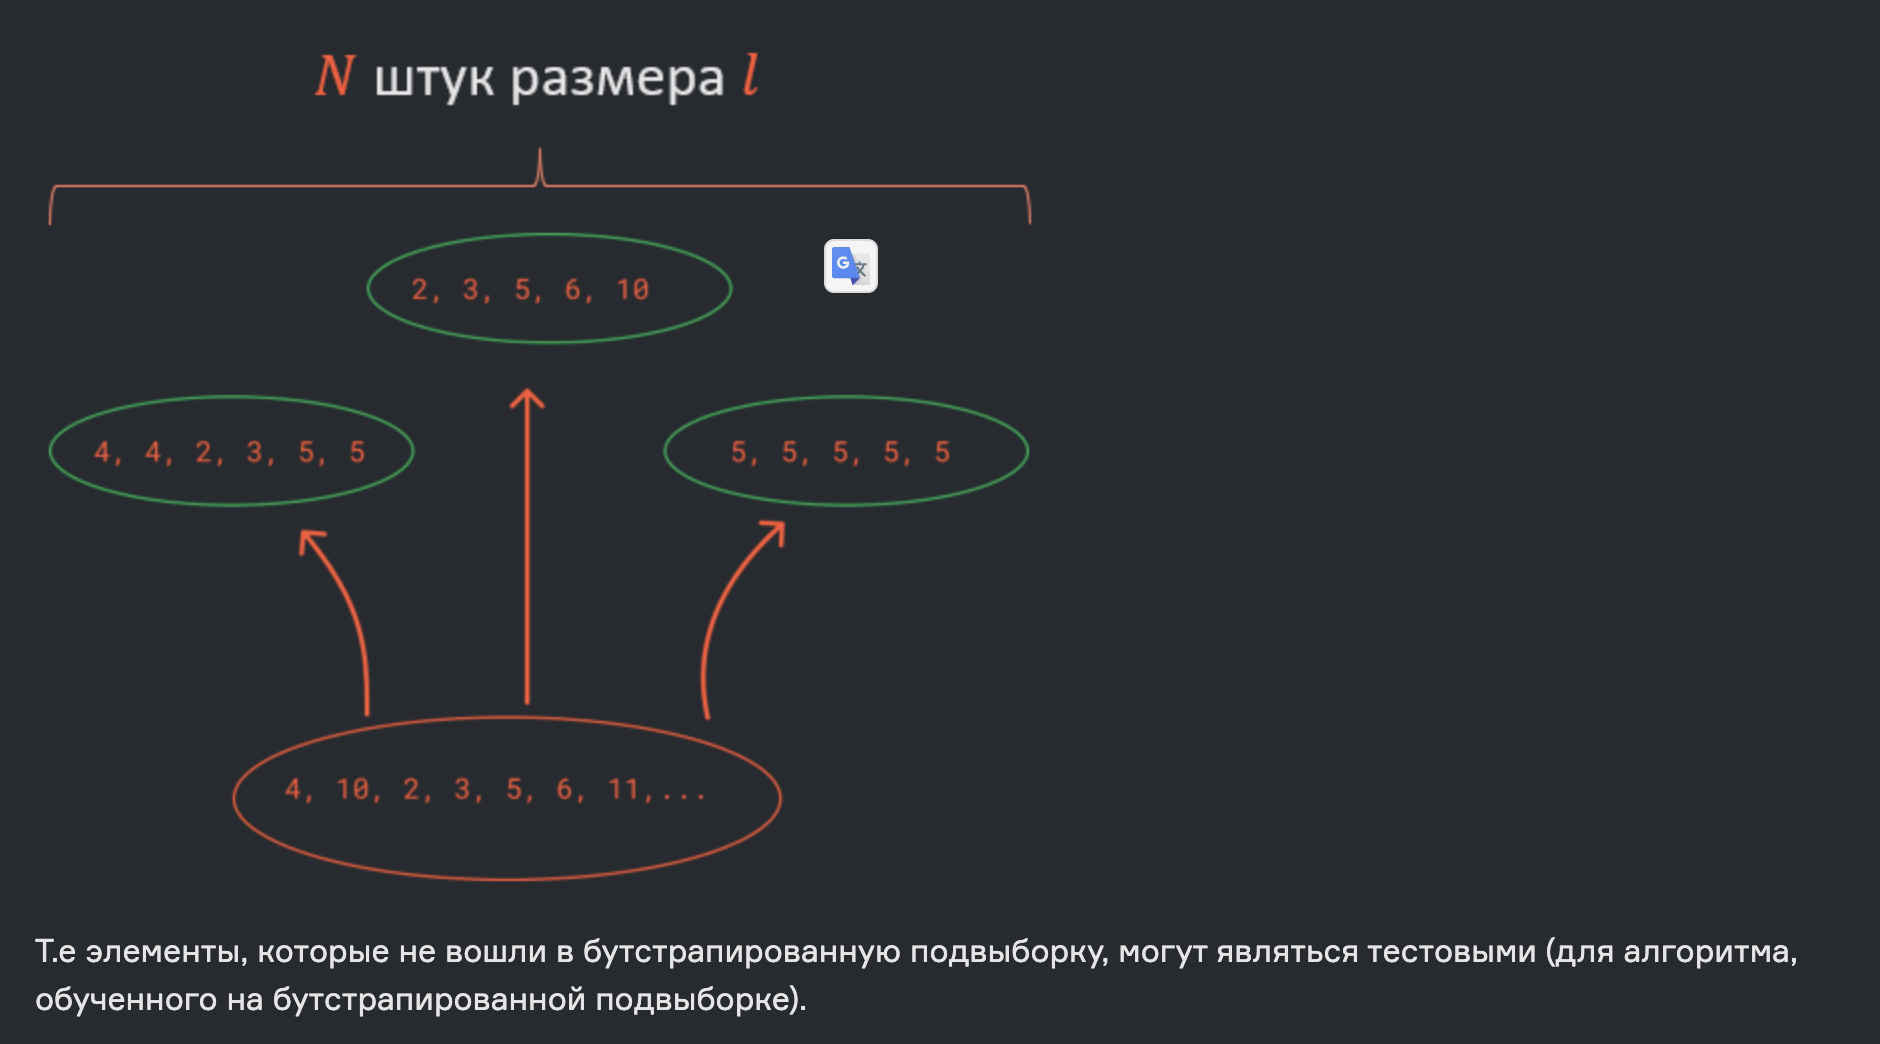

## Стекинг (от англ. stacking или stacked generalization) 
— это ансамбль моделей, в котором:

Несколько разных моделей (базовые модели) обучаются на исходных данных.  
Их предсказания подаются как признаки для финальной модели (мета-модели), которая учится объединять их в итоговый прогноз.

**Как работает стекинг (по шагам)**:

- Обучаем базовые модели (например: логистическая регрессия, дерево, градиентный бустинг).
- Делаем out-of-fold предсказания на тренировочных данных — чтобы избежать переобучения.
- Используем эти предсказания как новые признаки.
- Обучаем мета-модель (обычно простой алгоритм: логистическая регрессия, ridge и т.д.).

На тесте:

- получаем предсказания от базовых моделей,
- подаём их в мета-модель,
- получаем финальный результат.

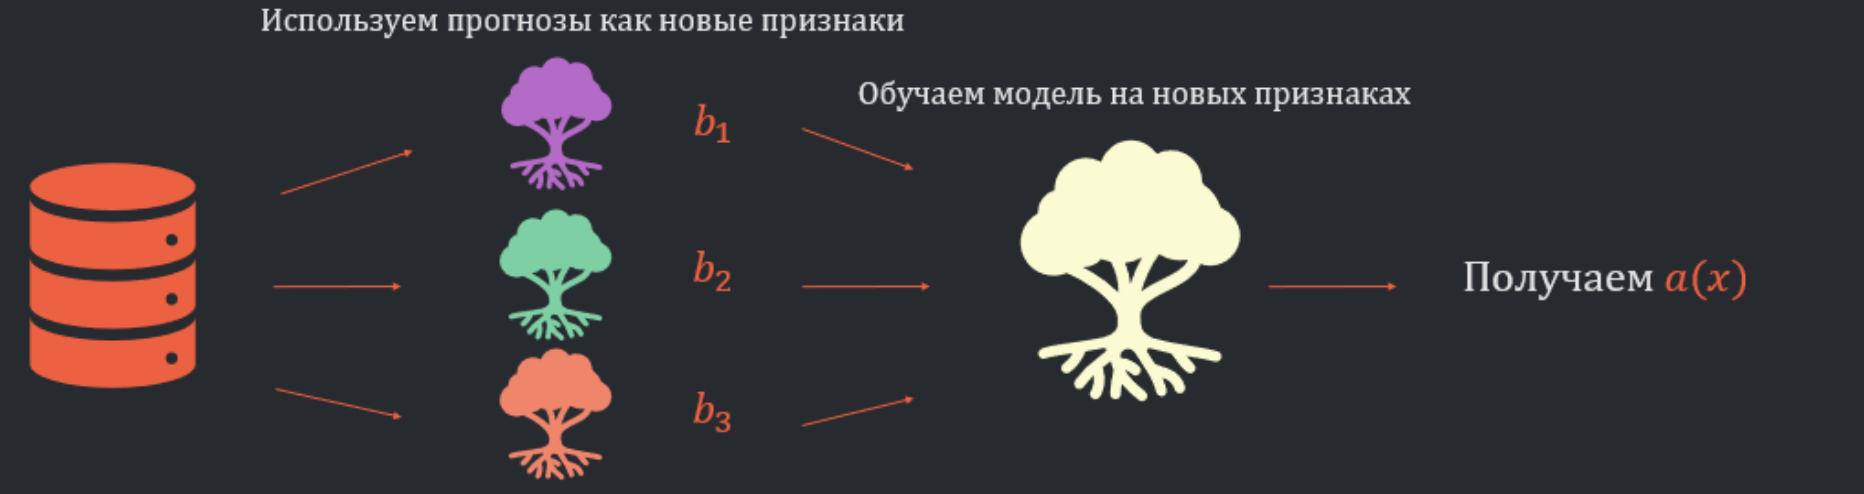

#### Out-of-fold предсказания 
— это предсказания модели на тех данных, на которых она НЕ обучалась, но которые при этом находятся внутри обучающей выборки.

Используется, чтобы:
- честно построить признаки для мета-модели в стекинге,
- получить реалистичную оценку качества модели без утечки данных.

🔄 Как это работает (пример с 5-фолд кросс-валидацией):
- Делим обучающую выборку на 5 частей (фолдов).  
Для каждого фолда:
- Обучаем модель на 4/5 данных,
- Предсказываем на оставшейся 1/5 — это и есть OOF-предсказания.
- Собираем все 5 частей — получаем предсказания на всей обучающей выборке, при этом каждая точка была предсказана вне фолда.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Данные
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Базовые модели
estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

# Стекинг
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# Обучаем
stacking.fit(X_train, y_train)

# Предсказываем
y_pred = stacking.predict(X_test)
print("Stacking accuracy:", accuracy_score(y_test, y_pred))
